In [28]:
# -- Imports and environment preparation ------------------------------------------------
import os
import math
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Add folium import and availability check
FOLIUM_AVAILABLE = False
try:
    import folium
    from folium.plugins import HeatMap
    FOLIUM_AVAILABLE = True
except ImportError:
    print("Folium not installed. Skipping interactive map functionality.")

In [29]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1AusGJFlRqnv858BOOvyLGVi5QLKde9pA')
df.head()

,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url
0,US,AK,aleutians east,63.588753,-154.493062,ICU,1000HAB,0.000000,3338,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...
1,US,AK,aleutians west,63.588753,-154.493062,ICU,1000HAB,0.000000,5784,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...
2,US,AK,anchorage,63.588753,-154.493062,ACUTE,1000HAB,2.182916,298225,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...
3,US,AK,anchorage,63.588753,-154.493062,ICU,1000HAB,0.244782,298225,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...
4,US,AK,anchorage,63.588753,-154.493062,OTHER,1000HAB,0.191131,298225,2019,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...


In [30]:
print("Loading dataset from:", df)
# df = pd.read_csv(df) # This line caused the error and has been commented out.
print("Dataset loaded. Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

Loading dataset from:      country state          county        lat         lng         type  \
0         US    AK  aleutians east  63.588753 -154.493062          ICU   
1         US    AK  aleutians west  63.588753 -154.493062          ICU   
2         US    AK       anchorage  63.588753 -154.493062        ACUTE   
3         US    AK       anchorage  63.588753 -154.493062          ICU   
4         US    AK       anchorage  63.588753 -154.493062        OTHER   
...      ...   ...             ...        ...         ...          ...   
5708      US    WY           uinta  43.075968 -107.290284        ACUTE   
5709      US    WY           uinta  43.075968 -107.290284          ICU   
5710      US    WY           uinta  43.075968 -107.290284  PSYCHIATRIC   
5711      US    WY        washakie  43.075968 -107.290284          ICU   
5712      US    WY          weston  43.075968 -107.290284          ICU   

      measure      beds  population  year  source  \
0     1000HAB  0.000000        3338 

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5713 entries, 0 to 5712
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     5713 non-null   object 
 1   state       5713 non-null   object 
 2   county      5713 non-null   object 
 3   lat         5713 non-null   float64
 4   lng         5713 non-null   float64
 5   type        5713 non-null   object 
 6   measure     5713 non-null   object 
 7   beds        5713 non-null   float64
 8   population  5713 non-null   int64  
 9   year        5713 non-null   int64  
 10  source      5713 non-null   object 
 11  source_url  5713 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 535.7+ KB


In [32]:
missing = df.isna().sum().sort_values(ascending=False)
missing

,0
country,0
state,0
county,0
lat,0
lng,0
type,0
measure,0
beds,0
population,0
year,0


In [33]:
dup_count = df.duplicated().sum()
dup_count

np.int64(0)

In [34]:
if dup_count>0:
    display(df[df.duplicated(keep=False)].head(5))

In [35]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols

['lat', 'lng', 'beds', 'population', 'year']

In [36]:
lat_cols = [c for c in df.columns if c.lower() in ('lat','latitude','y','latitud')]
lon_cols = [c for c in df.columns if c.lower() in ('lon','long','longitude','x','longitud')]
lat_col = lat_cols[0] if lat_cols else None
lon_col = lon_cols[0] if lon_cols else None
print("Detected lat/lon:", lat_col, lon_col)

Detected lat/lon: lat None


In [37]:
if (not lat_col or not lon_col) and numeric_cols:
    # look for columns with values in lat/lon ranges
    for c in numeric_cols:
        vals = df[c].dropna()
        if vals.shape[0]==0:
            continue
        vmin, vmax = vals.min(), vals.max()
        if -90 <= vmin <= 90 and -90 <= vmax <= 90 and lat_col is None:
            lat_col = c
        if -180 <= vmin <= 180 and -180 <= vmax <= 180 and lon_col is None:
            # don't overwrite lat
            if c!=lat_col:
                lon_col = c
print("Final lat/lon:", lat_col, lon_col)

Final lat/lon: lat lng


In [38]:
exclude = []
if lat_col: exclude.append(lat_col)
if lon_col: exclude.append(lon_col)
# Exclude obvious ID columns
id_like = [c for c in df.columns if 'id' in c.lower() or 'name' in c.lower() and c not in numeric_cols]
exclude += id_like

features = [c for c in numeric_cols if c not in exclude]
print("Features used for clustering (numeric):", features)

Features used for clustering (numeric): ['beds', 'population', 'year']


In [39]:
if len(features)==0:
    print("No numeric features selected; attempting to coerce some columns to numeric (force).")
    for c in df.columns:
        try:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        except:
            pass
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    features = [c for c in numeric_cols if c not in exclude]
    print("New numeric features:", features)

In [40]:
before = df.shape[0]
df_clean = df.dropna(subset=features).copy()
after = df_clean.shape[0]
print(f"Dropping rows with missing values in features: {before-after} rows removed. Remaining: {after}")

Dropping rows with missing values in features: 0 rows removed. Remaining: 5713


In [41]:
df_clean = df_clean.drop_duplicates().reset_index(drop=True)
df_clean

,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url
0,US,AK,aleutians east,63.588753,-154.493062,ICU,1000HAB,0.000000,3338,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...
1,US,AK,aleutians west,63.588753,-154.493062,ICU,1000HAB,0.000000,5784,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...
2,US,AK,anchorage,63.588753,-154.493062,ACUTE,1000HAB,2.182916,298225,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...
3,US,AK,anchorage,63.588753,-154.493062,ICU,1000HAB,0.244782,298225,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...
4,US,AK,anchorage,63.588753,-154.493062,OTHER,1000HAB,0.191131,298225,2019,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...
...,...,...,...,...,...,...,...,...,...,...,...,...
5708,US,WY,uinta,43.075968,-107.290284,ACUTE,1000HAB,2.023316,20758,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...
5709,US,WY,uinta,43.075968,-107.290284,ICU,1000HAB,0.289045,20758,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...
5710,US,WY,uinta,43.075968,-107.290284,PSYCHIATRIC,1000HAB,8.815878,20758,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...
5711,US,WY,washakie,43.075968,-107.290284,ICU,1000HAB,2.181025,8253,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...


In [42]:
print("\nNumeric features summary:")
display(df_clean[features].describe().T)


Numeric features summary:


,count,mean,std,min,25%,50%,75%,max
beds,5713.0,1.647644,3.101818,0.0,0.141784,0.616614,2.225851,9.046635e+01
population,5713.0,171698.325923,462437.558681,74.0,17088.000000,42826.000000,137096.000000,1.010572e+07
year,5713.0,2018.280763,0.907452,2012.0,2018.000000,2018.000000,2019.000000,2.020000e+03


In [43]:
#normalisasi
scaler = RobustScaler()
X = scaler.fit_transform(df_clean[features])
X_df = pd.DataFrame(X, columns=features)
print("\nAfter RobustScaler: feature ranges (min/max):")
display(X_df.agg(['min','max']).T)


After RobustScaler: feature ranges (min/max):


,min,max
beds,-0.295871,43.112692
population,-0.356243,83.851877
year,-6.000000,2.000000


In [44]:

# Correlation matrix
corr = pd.DataFrame(X, columns=features).corr(method='spearman')
print("Spearman correlation (showing top absolute correlations):")
display(corr)

Spearman correlation (showing top absolute correlations):


,beds,population,year
beds,1.000000,0.009169,-0.747503
population,0.009169,1.000000,-0.140495
year,-0.747503,-0.140495,1.000000


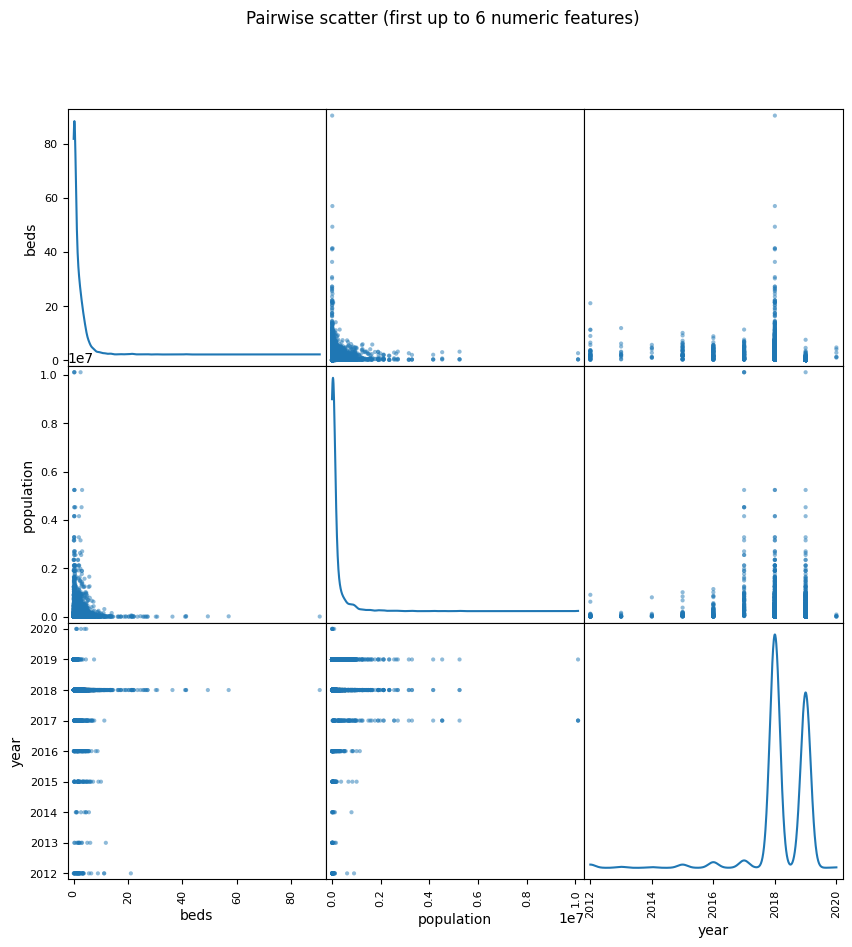

In [45]:
sample_feats = features[:6]
pd.plotting.scatter_matrix(df_clean[sample_feats], figsize=(10,10), diagonal='kde')
plt.suptitle("Pairwise scatter (first up to 6 numeric features)")
plt.show()

In [48]:
if FOLIUM_AVAILABLE and lat_col and lon_col:
    print("\nCreating folium heatmap (interactive).")
    # Prepare data for HeatMap: list of [lat, lon, weight]
    heat_data = df_clean[[lat_col, lon_col]].dropna().values.tolist()
    m = folium.Map(location=[np.nanmean(df_clean[lat_col]), np.nanmean(df_clean[lon_col])], zoom_start=5)
    HeatMap(heat_data, radius=8, blur=10, max_zoom=13).add_to(m)
    # Save to html
    map_path = "hospital_beds_heatmap.html" # Changed path to current directory
    m.save(map_path)
    print(f"Heatmap saved to {map_path}")
else:
    if not FOLIUM_AVAILABLE:
        print("\nFolium not available — skipping interactive spatial heatmap.")
    elif not (lat_col and lon_col):
        print("\nNo lat/lon columns detected — skipping spatial heatmap.")


Creating folium heatmap (interactive).
Heatmap saved to hospital_beds_heatmap.html


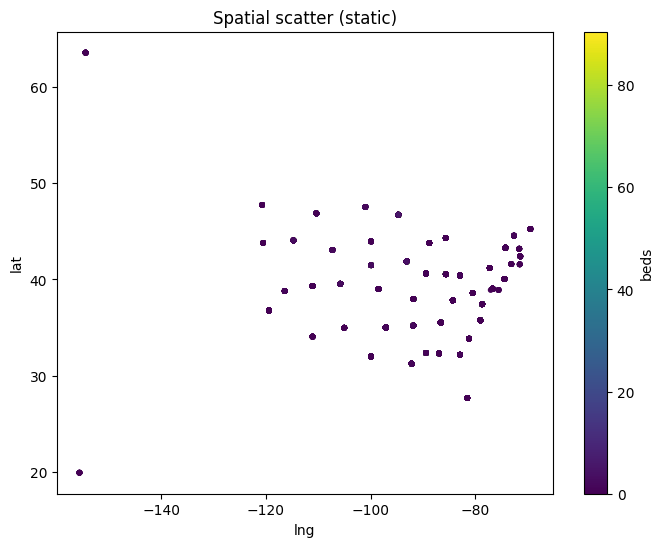

In [49]:
if lat_col and lon_col:
    plt.figure(figsize=(8,6))
    if len(features)>0:
        # color by first feature
        plt.scatter(df_clean[lon_col], df_clean[lat_col], c=df_clean[features[0]], s=10)
        plt.colorbar(label=features[0])
    else:
        plt.scatter(df_clean[lon_col], df_clean[lat_col], s=10)
    plt.xlabel(lon_col); plt.ylabel(lat_col)
    plt.title("Spatial scatter (static)")
    plt.show()


--- k-distance graph to choose eps ---


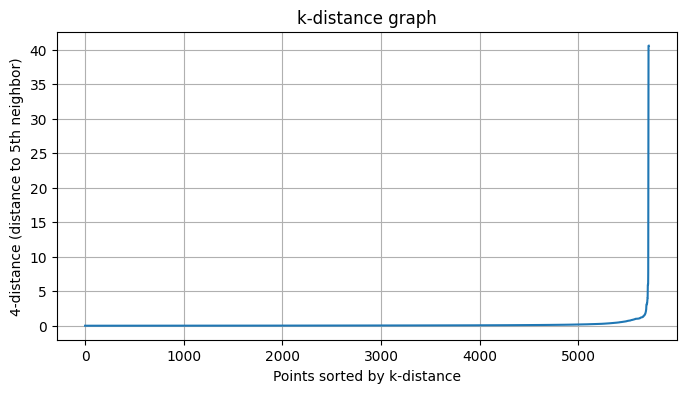

In [50]:
print("\n--- k-distance graph to choose eps ---")
min_samples = 5
k = min_samples - 1  # for NearestNeighbors: the k-th neighbor (excluding itself)
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = nbrs.kneighbors(X)
# take the distance to the k-th neighbor (last column)
k_distances = np.sort(distances[:, -1])
plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.xlabel("Points sorted by k-distance")
plt.ylabel(f"{k}-distance (distance to {min_samples}th neighbor)")
plt.title("k-distance graph")
plt.grid(True)
plt.show()

In [51]:
d1 = np.gradient(k_distances)
d2 = np.gradient(d1)
elbow_idx = np.argmax(d2)
eps_suggest = float(k_distances[elbow_idx])
print(f"Elbow index detected at {elbow_idx}, suggested eps = {eps_suggest:.4f}")
# Also show 90th percentile as alternative suggestion
eps_90 = float(np.percentile(k_distances, 90))
print(f"90th percentile of k-distances: {eps_90:.4f}")

Elbow index detected at 5707, suggested eps = 7.7001
90th percentile of k-distances: 0.2289


In [52]:
eps_to_try = [eps_suggest, eps_90]
results = []
for eps in eps_to_try:
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(X)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    results.append((eps, n_clusters, n_noise))
print("\nTrial DBSCAN summary (eps, n_clusters, n_noise):")
for r in results:
    print(r)


Trial DBSCAN summary (eps, n_clusters, n_noise):
(7.700124130452768, 1, 5)
(0.22894967583624015, 21, 461)


In [53]:
chosen_eps = None
for eps, ncl, nnoise in results:
    if ncl >= 2:
        chosen_eps = eps
        break
# fallback to the eps_suggest
if chosen_eps is None:
    chosen_eps = eps_suggest
print(f"Chosen eps = {chosen_eps:.4f}")

Chosen eps = 0.2289


In [54]:
db = DBSCAN(eps=chosen_eps, min_samples=min_samples, metric='euclidean')
labels = db.fit_predict(X)
df_clean['dbscan_label'] = labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"\nDBSCAN result: clusters = {n_clusters}, noise points = {n_noise}")



DBSCAN result: clusters = 21, noise points = 461


In [55]:
sil_score = None
if n_clusters >= 2:
    try:
        # silhouette_score requires at least 2 labels and no singletons? It allows.
        sil_score = silhouette_score(X, labels, metric='euclidean')
        print(f"Silhouette Score: {sil_score:.4f}")
    except Exception as e:
        print("Could not compute Silhouette Score:", e)
else:
    print("Silhouette Score not computed (less than 2 clusters).")


Silhouette Score: 0.1920


In [56]:
cluster_counts = df_clean['dbscan_label'].value_counts().sort_index()
print("\nCluster counts (label: count):")
print(cluster_counts)


Cluster counts (label: count):
dbscan_label
-1      461
 0     2210
 1     2751
 2       90
 3       25
 4       71
 5        9
 6        6
 7       13
 8        6
 9        7
 10       8
 11       5
 12       5
 13       5
 14       9
 15       5
 16       7
 17       5
 18       5
 19       5
 20       5
Name: count, dtype: int64


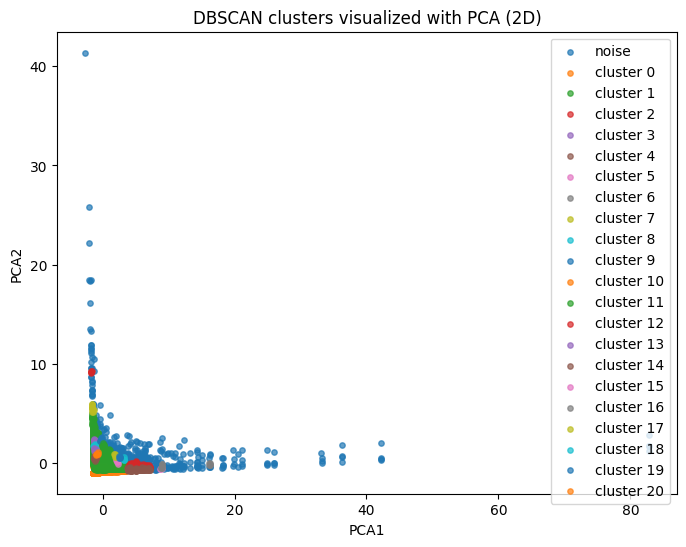

In [57]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8,6))
unique_labels = sorted(list(set(labels)))
colors = plt.cm.get_cmap('tab10', len(unique_labels))
for i, lab in enumerate(unique_labels):
    mask = labels == lab
    lab_name = f"noise" if lab == -1 else f"cluster {lab}"
    plt.scatter(X_pca[mask,0], X_pca[mask,1], s=15, label=lab_name, alpha=0.7)
plt.legend()
plt.title("DBSCAN clusters visualized with PCA (2D)")
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.show()


In [60]:
print("\n--- Cluster summary (means of numeric features) ---")
cluster_summary = df_clean.groupby('dbscan_label')[features].mean().T
display(cluster_summary)


--- Cluster summary (means of numeric features) ---


dbscan_label,-1,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
beds,4.545974,0.152910,2.321673,0.414084,2.086127,0.282663,1.913854,3.766495e-01,13.481118,4.355195,...,5.345989,21.347903,1.881401,1.552631,3.907922e-01,2.820891e-01,3.090233,2.195673,2.58967,0.432155
population,874671.184382,73361.124434,87857.951290,817611.433333,16424.080000,812907.845070,441148.666667,2.117258e+06,6869.153846,29156.333333,...,188680.200000,4737.400000,19015.000000,28230.222222,1.241427e+06,1.245435e+06,401400.800000,556479.400000,486576.60000,60964.000000
year,2017.082430,2019.000000,2018.000000,2018.000000,2012.000000,2019.000000,2018.000000,2.018000e+03,2018.000000,2016.000000,...,2018.000000,2018.000000,2013.000000,2016.000000,2.019000e+03,2.018000e+03,2018.000000,2018.000000,2018.00000,2012.000000


In [61]:
summary_counts = df_clean['dbscan_label'].value_counts().rename("count")
summary_prop = (df_clean['dbscan_label'].value_counts(normalize=True).rename("proportion"))
summary_df = pd.concat([summary_counts, summary_prop], axis=1).sort_index()
display(summary_df)

,count,proportion
dbscan_label,,
-1,461,0.080693
0,2210,0.386837
1,2751,0.481533
2,90,0.015754
3,25,0.004376
4,71,0.012428
5,9,0.001575
6,6,0.001050
7,13,0.002276


In [62]:
examples = {}
for lab in sorted(df_clean['dbscan_label'].unique()):
    examples[lab] = df_clean[df_clean['dbscan_label']==lab].head(3)
    print(f"\nExamples for label {lab}:")
    display(examples[lab].head(3))


Examples for label -1:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
73,US,AL,covington,32.318231,-86.902298,ACUTE,1000HAB,5.597164,37519,2016,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,-1
112,US,AL,jefferson,32.318231,-86.902298,ACUTE,1000HAB,6.672126,659460,2017,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,-1
128,US,AL,madison,32.318231,-86.902298,ACUTE,1000HAB,3.080294,353213,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,-1



Examples for label 0:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
0,US,AK,aleutians east,63.588753,-154.493062,ICU,1000HAB,0.000000,3338,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...,0
1,US,AK,aleutians west,63.588753,-154.493062,ICU,1000HAB,0.000000,5784,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...,0
3,US,AK,anchorage,63.588753,-154.493062,ICU,1000HAB,0.244782,298225,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...,0



Examples for label 1:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
2,US,AK,anchorage,63.588753,-154.493062,ACUTE,1000HAB,2.182916,298225,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,1
5,US,AK,anchorage,63.588753,-154.493062,PSYCHIATRIC,1000HAB,0.938888,298225,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,1
6,US,AK,bethel,63.588753,-154.493062,ICU,1000HAB,2.060478,17957,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,1



Examples for label 2:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
114,US,AL,jefferson,32.318231,-86.902298,OTHER,1000HAB,1.129712,659460,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,2
115,US,AL,jefferson,32.318231,-86.902298,PSYCHIATRIC,1000HAB,0.142541,659460,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,2
330,US,AZ,pima,34.048928,-111.093731,OTHER,1000HAB,0.734669,1007257,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,2



Examples for label 3:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
233,US,AR,howard,35.201050,-91.831833,ICU,1000HAB,1.855701,13472,2012,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,3
265,US,AR,pike,35.201050,-91.831833,ACUTE,1000HAB,2.937666,10893,2012,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,3
858,US,GA,chattooga,32.157435,-82.907123,ACUTE,1000HAB,1.245981,24880,2012,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,3



Examples for label 4:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
113,US,AL,jefferson,32.318231,-86.902298,ICU,1000HAB,0.714221,659460,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...,4
329,US,AZ,pima,34.048928,-111.093731,ICU,1000HAB,0.293867,1007257,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...,4
366,US,CA,fresno,36.778261,-119.417932,ICU,1000HAB,0.168791,971616,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...,4



Examples for label 5:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
407,US,CA,monterey,36.778261,-119.417932,ACUTE,1000HAB,1.830698,433168,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,5
453,US,CA,santa barbara,36.778261,-119.417932,ACUTE,1000HAB,2.180607,442996,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,5
471,US,CA,solano,36.778261,-119.417932,ACUTE,1000HAB,1.544895,434981,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,5



Examples for label 6:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
435,US,CA,san bernardino,36.778261,-119.417932,OTHER,1000HAB,0.228171,2121220,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,6
436,US,CA,san bernardino,36.778261,-119.417932,PSYCHIATRIC,1000HAB,0.698655,2121220,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,6
3542,US,NV,clark,38.802610,-116.419389,OTHER,1000HAB,0.525460,2112436,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,6



Examples for label 7:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
403,US,CA,modoc,36.778261,-119.417932,ACUTE,1000HAB,12.531884,9017,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,7
467,US,CA,sierra,36.778261,-119.417932,ACUTE,1000HAB,13.518198,2885,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,7
1775,US,KS,republic,39.011902,-98.484246,ICU,1000HAB,13.390011,4705,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,7



Examples for label 8:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
798,US,FL,taylor,27.664827,-81.515754,ACUTE,1000HAB,4.295302,22350,2016,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,8
1043,US,GA,stewart,32.157435,-82.907123,ICU,1000HAB,4.286694,5832,2016,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,8
4377,US,SD,brown,43.969515,-99.901813,ACUTE,1000HAB,4.451691,38637,2016,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,8



Examples for label 9:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
829,US,GA,bibb,32.157435,-82.907123,ACUTE,1000HAB,6.652677,153923,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,9
1218,US,IA,scott,41.878003,-93.097702,ACUTE,1000HAB,6.664995,171493,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,9
1820,US,KS,wyandotte,39.011902,-98.484246,ACUTE,1000HAB,7.082162,163227,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,9



Examples for label 10:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
933,US,GA,gilmer,32.157435,-82.907123,ACUTE,1000HAB,1.688391,29614,2015,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,10
1022,US,GA,polk,32.157435,-82.907123,ICU,1000HAB,1.713155,41444,2015,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,10
2511,US,MN,goodhue,46.729553,-94.685900,ACUTE,1000HAB,1.538862,46138,2015,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,10



Examples for label 11:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
1006,US,GA,muscogee,32.157435,-82.907123,ACUTE,1000HAB,5.336099,198647,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,11
1428,US,IL,peoria,40.633125,-89.398528,ACUTE,1000HAB,5.758951,186145,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,11
1627,US,IN,vanderburgh,40.551217,-85.602364,ACUTE,1000HAB,5.142137,181831,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,11



Examples for label 12:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
1368,US,IL,greene,40.633125,-89.398528,ICU,1000HAB,21.485989,13311,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,12
1671,US,KS,clark,39.011902,-98.484246,ICU,1000HAB,21.541407,2089,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,12
1681,US,KS,decatur,39.011902,-98.484246,ACUTE,1000HAB,21.099965,2891,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,12



Examples for label 13:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
1650,US,KS,allen,39.011902,-98.484246,ACUTE,1000HAB,1.960477,12752,2013,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,13
2449,US,MI,presque isle,44.314844,-85.602364,OTHER,1000HAB,2.178310,12854,2013,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,13
2695,US,MO,lawrence,37.964253,-91.831833,OTHER,1000HAB,2.071805,38131,2013,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,13



Examples for label 14:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
1610,US,IN,shelby,40.551217,-85.602364,ACUTE,1000HAB,1.623853,44339,2016,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,14
2138,US,LA,st. john the baptist,31.244823,-92.145024,ACUTE,1000HAB,1.423161,43565,2016,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,14
2561,US,MN,pine,46.729553,-94.685900,ICU,1000HAB,1.032453,29057,2016,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,14



Examples for label 15:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
2435,US,MI,oakland,44.314844,-85.602364,ICU,1000HAB,0.329345,1241860,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...,15
2516,US,MN,hennepin,46.729553,-94.685900,ICU,1000HAB,0.253927,1224763,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...,15
3742,US,OH,cuyahoga,40.417287,-82.907123,ICU,1000HAB,0.540798,1257401,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...,15



Examples for label 16:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
2436,US,MI,oakland,44.314844,-85.602364,OTHER,1000HAB,0.048315,1241860,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,16
2517,US,MN,hennepin,46.729553,-94.685900,OTHER,1000HAB,0.032659,1224763,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,16
3743,US,OH,cuyahoga,40.417287,-82.907123,OTHER,1000HAB,0.752346,1257401,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,16



Examples for label 17:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
781,US,FL,sarasota,27.664827,-81.515754,ACUTE,1000HAB,3.448284,404839,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,17
2110,US,LA,orleans,31.244823,-92.145024,ACUTE,1000HAB,3.397891,388182,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,17
2362,US,MI,genesee,44.314844,-85.602364,ACUTE,1000HAB,2.781827,410881,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,17



Examples for label 18:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
644,US,FL,brevard,27.664827,-81.515754,ACUTE,1000HAB,2.580155,568183,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,18
2186,US,MA,bristol,42.407211,-71.382437,ACUTE,1000HAB,2.084321,557016,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,18
3465,US,NJ,union,40.058324,-74.405661,ACUTE,1000HAB,2.210579,557320,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,18



Examples for label 19:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
766,US,FL,pasco,27.664827,-81.515754,ACUTE,1000HAB,2.392921,498136,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,19
2198,US,MA,hampden,42.407211,-71.382437,ACUTE,1000HAB,2.817634,469188,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,19
3447,US,NJ,morris,40.058324,-74.405661,ACUTE,1000HAB,2.565917,498847,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,19



Examples for label 20:


,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url,dbscan_label
2169,US,LA,washington,31.244823,-92.145024,OTHER,1000HAB,0.430580,46449,2012,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,20
3713,US,OH,athens,40.417287,-82.907123,ICU,1000HAB,0.381313,65563,2012,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,20
4082,US,OR,umatilla,43.804133,-120.554201,ICU,1000HAB,0.325792,76736,2012,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...,20
